In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 30, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [4]:
#pos_neg("インディアンス", year=2017)

In [6]:
res = []
for team in teams_mlb:
    curr = pos_neg(team)
    res.append(curr)
    print(curr)

['カージナルス', 0.92960508976286227, 0.88635689644636106, 1.0007265355170931, 0.74879208925914387, 0.83740717763739725, 0.95140916065399295]
['レンジャーズ', 0.95935764102904708, 0.96651778918007725, 0.88843081392174073, 1.0481554378555398, 0.7539944053571459, 0.90933509718925809]
['ロイヤルズ', 1.0398729046852799, 0.78732698945353796, 0.98302121165305101, 0.61580446473592432, 1.0079249341427858, 0.98919268857184872]
['パドレス', 0.81069432595968483, 0.89223366600251386, 1.015829603084313, 0.063466306062654951, 0.83748518302970232, 0.96740254071841369]
['ヤンキース', 1.09351482299923, 0.99873769099775744, 1.2422252897106765, 1.0662915682516463, 0.85390033742356775, 0.79815221234334199]
['フィリーズ', 0.87676551924045154, 0.77989137597657598, 1.0874367922834098, 0.90420034690788964, 0.77081731056009062, 0.81419646897320019]
['インディアンス', 0.95543236126094733, 1.0176031661782745, 0.96285254835965084, 0.93610943647482125, 0.86979927603217222, 0.96294037142918099]
['ブリュワーズ', 1.0442962501441819, 0.9413936044140282, 1.39168

In [7]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [8]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

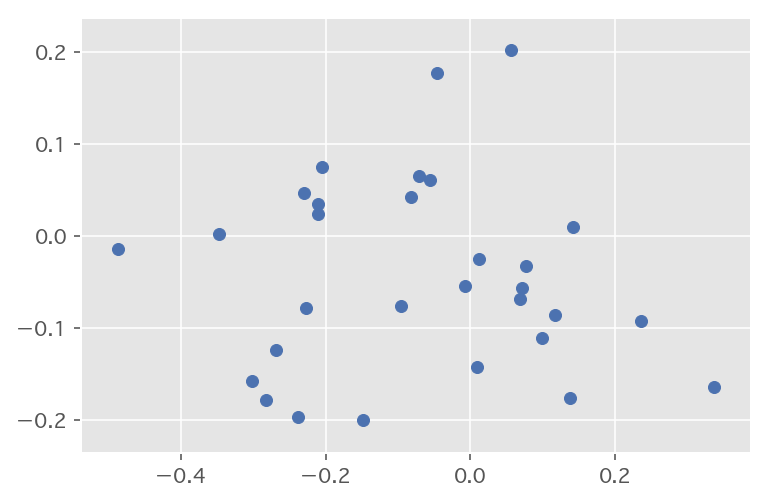

In [9]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [10]:
df

,all_imp,all_det,pos_imp,pos_det,neg_imp,neg_det,positive_inhibition,negative_facilitation
チーム,,,,,,,,
カージナルス,0.929605,0.886357,1.000727,0.748792,0.837407,0.951409,-0.071121,0.065052
レンジャーズ,0.959358,0.966518,0.888431,1.048155,0.753994,0.909335,0.070927,-0.057183
ロイヤルズ,1.039873,0.787327,0.983021,0.615804,1.007925,0.989193,0.056852,0.201866
パドレス,0.810694,0.892234,1.015830,0.063466,0.837485,0.967403,-0.205135,0.075169
ヤンキース,1.093515,0.998738,1.242225,1.066292,0.853900,0.798152,-0.148710,-0.200585
フィリーズ,0.876766,0.779891,1.087437,0.904200,0.770817,0.814196,-0.210671,0.034305
インディアンス,0.955432,1.017603,0.962853,0.936109,0.869799,0.962940,-0.007420,-0.054663
ブリュワーズ,1.044296,0.941394,1.391686,0.495946,0.961080,0.943722,-0.347389,0.002328
パイレーツ,0.893305,0.628882,1.120886,0.958891,0.775855,0.550339,-0.227581,-0.078544


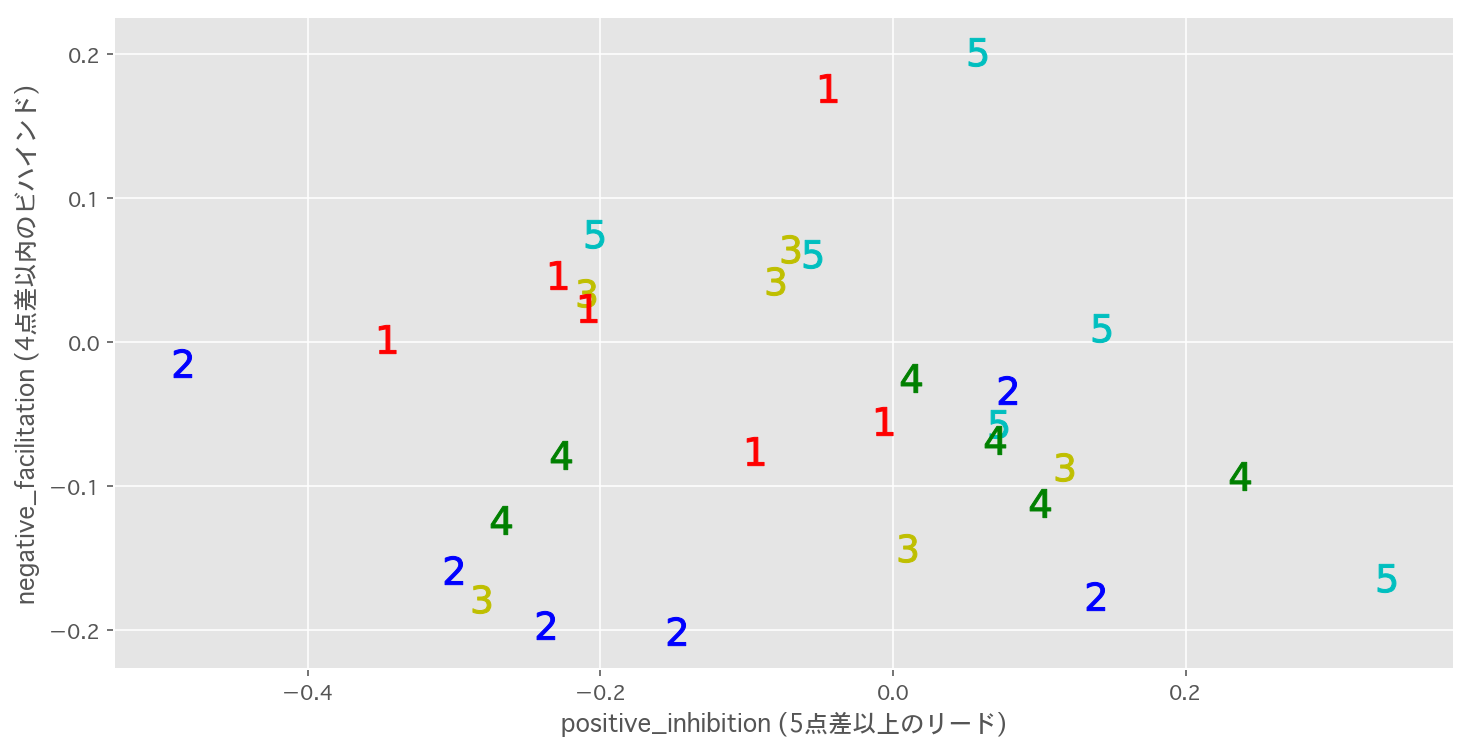

In [12]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team)), color=colors[ranking(team)-1], s=200)
plt.xlabel("positive_inhibition (5点差以上のリード)")
plt.ylabel("negative_facilitation (4点差以内のビハインド)")

In [21]:
order_pos_dict = defaultdict(int)
for team in df.index:
    order_pos_dict[ranking(team, 2017)] += df.loc[team, "positive_inhibition"]

In [22]:
order_pos_dict

defaultdict(int,
            {1: -1.2808245279289476,
             2: -0.82843647603706194,
             3: -0.4208273463319725,
             4: -0.18190127196350925,
             5: 0.55946766902516554})

In [23]:
order_neg_dict = defaultdict(int)
for team in df.index:
    order_neg_dict[ranking(team, 2017)] += df.loc[team, "negative_facilitation"]

In [24]:
order_neg_dict

defaultdict(int,
            {1: 0.019413391611952213,
             2: -0.52413584865632545,
             3: -0.1065880459030244,
             4: -0.26577716070227309,
             5: -0.42483051525492987})

In [25]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T

,positive_inhibition,negative_facilitation
1,-1.280825,0.019413
2,-0.828436,-0.524136
3,-0.420827,-0.106588
4,-0.181901,-0.265777
5,0.559468,-0.424831


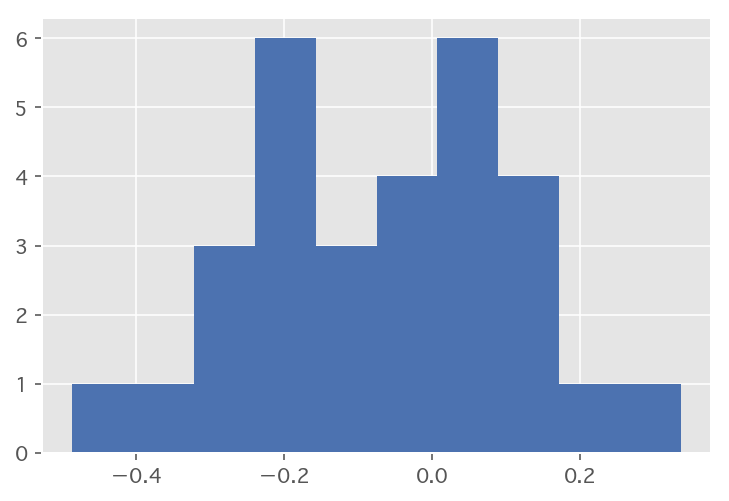

In [26]:
df.loc[:, "positive_inhibition"].hist()

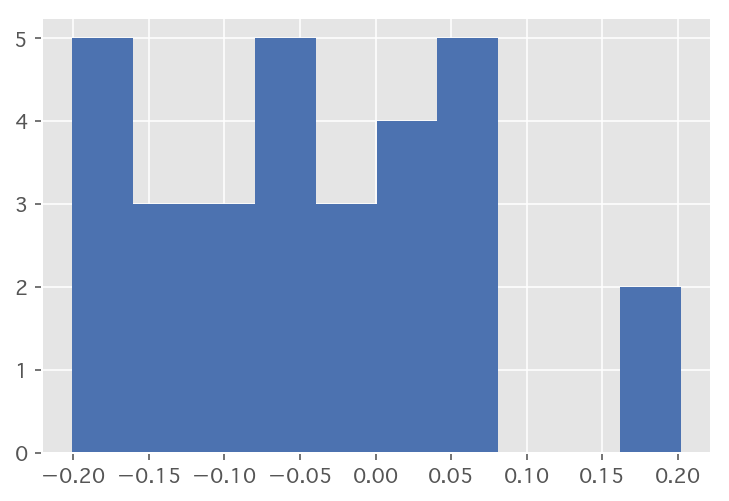

In [27]:
df.loc[:, "negative_facilitation"].hist()